In [ ]:
import torch # 파이토치 기본 라이브러리 
import torchvision # 이미지 관련 된 파이토치 라이브러리
from torchvision import datasets # 토치비전에서 제공하는 데이터셋
from torchvision import transforms # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader # 데이터를 모델에 사용할 수 있도록 적재해 주는 라이브러리
from torch.utils.data import random_split
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
import glob
from torch.utils.data import Dataset
from PIL import Image
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models

In [ ]:
!nvidia-smi

Thu May 26 04:04:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 탐색

In [ ]:
import pandas as pd

data_path = "/content/drive/MyDrive/"

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [ ]:
train.shape, test.shape

((1821, 5), (1821, 1))

In [ ]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
healthy = train.loc[train['healthy'] == 1]
multiple_diseases = train.loc[train['multiple_diseases'] == 1]
rust = train.loc[train['rust'] == 1]
scab = train.loc[train['scab'] == 1]

([<matplotlib.patches.Wedge at 0x7efd4c934390>,
 [Text(0.6921787180836257, 0.8549202431993926, 'healthy'),
  Text(-0.3942932497177081, 1.0269044908008969, 'multiple_diseases'),
  Text(-1.0996317038245758, -0.028462535794632142, 'rust'),
  Text(0.5744651016901711, -0.9380777403499678, 'scab')],
 [Text(0.377552028045614, 0.4663201326542141, '28.3%'),
  Text(-0.21506904530056806, 0.5601297222550347, '5.0%'),
  Text(-0.5997991111770412, -0.015525019524344801, '34.2%'),
  Text(0.31334460092191146, -0.5116787674636187, '32.5%')])

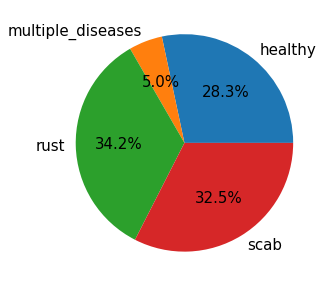

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size = 15)
plt.figure(figsize = (5,5))
label = ['healthy', 'multiple_diseases', 'rust', 'scab']

plt.pie([len(healthy), len(multiple_diseases),len(rust),len(scab)],
        labels = label, autopct = '%.1f%%')

In [ ]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(train,
                               test_size = 0.1,
                               stratify = train[['healthy', 'multiple_diseases', 'rust', 'scab']],
                               random_state = 50)

## 데이터셋 형성

In [ ]:
import cv2
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, df, img_dir = './', transform = None, is_test = False):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
      
    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        img_id = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_id + '.jpg'
        image = Image.open(img_path)
        

        if self.transform is not None:
            image = self.transform(image)

        if self.is_test:
            return image
        else:
            label = self.df.iloc[idx, 1:5].values.astype(np.float32)
            return image, label


## 이미지 증강용 transformer

In [ ]:
from torchvision.transforms.transforms import Resize
from torchvision import transforms

transform = transforms.Compose([transforms.Resize([400,600]),
                               transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [ ]:
img_dir = '/content/drive/MyDrive/images/'
dataset_train = ImageDataset(train, img_dir = img_dir, transform = transform)
dataset_valid = ImageDataset(valid, img_dir = img_dir, transform = transform)

In [ ]:
dataset_train[100][1] # array([0., 0., 0., 1.]

array([0., 0., 0., 1.], dtype=float32)

## 데이터셋 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


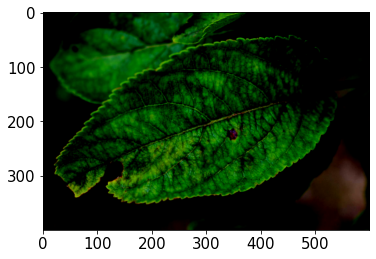

In [ ]:
plt.imshow(dataset_train[100][0].permute(1, 2, 0))

## batch size 별 데이터셋 분배

In [ ]:
batch_size = 32 # 중요한 하이퍼 파라미터, 16 이하로 사용하는것이 성능에 좋다고 알려져 있음
trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # 훈련용
validloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False) # 테스트용

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next() # 32개의 image, 32개의 label
print(torch.argmax(labels, dim=1))


tensor([2, 3, 3, 1, 2, 3, 0, 3, 0, 2, 3, 0, 2, 2, 3, 0, 2, 0, 2, 3, 0, 2, 2, 2,
        3, 3, 2, 0, 3, 3, 2, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


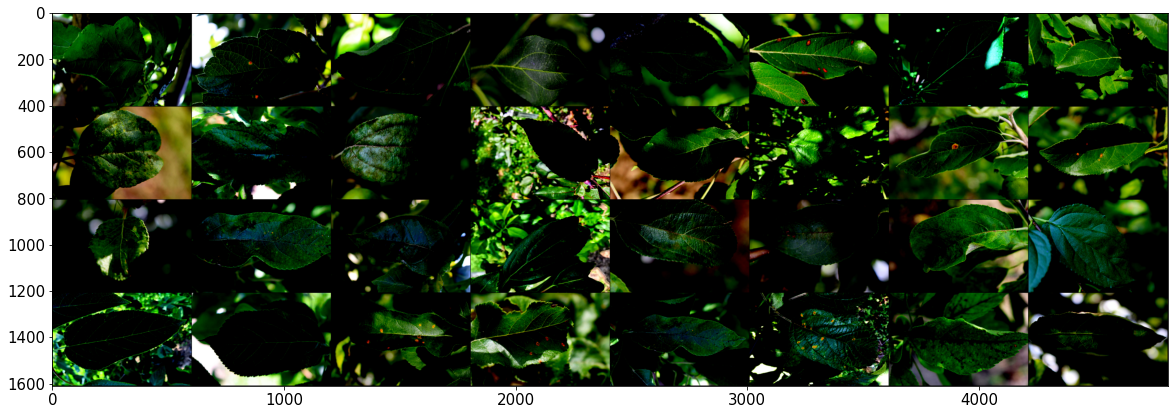

In [ ]:
def imshow(img):         
    #img = img * 0.5 + 0.5 #unnormalize (normalize : (data - 0.5)/0.5))
    plt.figure(figsize=(20, 200))
    plt.imshow(img.permute(1, 2, 0))

dataiter = iter(trainloader)
images, labels = dataiter.next() # 32개의 image, 32개의 label

imshow(torchvision.utils.make_grid(images, nrows=8))

## 모델 불러오기

In [ ]:
vgg16 = models.vgg16(pretrained=True)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in vgg16.parameters(): # 전이학습에서 가져온 gradient값이 변경안되게 만듬
  param.requires_grad = False


vgg16.classifier[3] = nn.Linear(in_features=4096, out_features=512) # in_out features값 변경
vgg16.classifier[6] = nn.Linear(in_features=512, out_features=4)


for param in vgg16.classifier.parameters(): # 전이학습에서 가져온 gradient값이 중에서 학습이 됐으면 하는 층만 학습되게 변경
    param.requires_grad = True

In [ ]:
vgg16.to(device) # model을 GPU로 보내기

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
summary(vgg16, (3, 400, 600))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 200]           1,792
              ReLU-2         [-1, 64, 150, 200]               0
            Conv2d-3         [-1, 64, 150, 200]          36,928
              ReLU-4         [-1, 64, 150, 200]               0
         MaxPool2d-5          [-1, 64, 75, 100]               0
            Conv2d-6         [-1, 128, 75, 100]          73,856
              ReLU-7         [-1, 128, 75, 100]               0
            Conv2d-8         [-1, 128, 75, 100]         147,584
              ReLU-9         [-1, 128, 75, 100]               0
        MaxPool2d-10          [-1, 128, 37, 50]               0
           Conv2d-11          [-1, 256, 37, 50]         295,168
             ReLU-12          [-1, 256, 37, 50]               0
           Conv2d-13          [-1, 256, 37, 50]         590,080
             ReLU-14          [-1, 256,

## 옵티마이저

In [ ]:
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss() # 손실함수
optimizer = optim.Adam(vgg16.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=7, factor=0.1, verbose=True)

## 모델 훈련

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
def validation(model, testloader, criterion):
    test_loss = 0
    preds_list = []
    labels_list = []
    test_accuracy = 0

    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for images, labels in testloader: # 1 iteration마다 배치 단위로 image와 label을 가져옴
            images, labels = images.to(device), labels.to(device) # data를 GPU로 보내기
            # Not Flatten!!!
            #images.resize_(images.shape[0], 784) # batch size x 784
            
            logits = model.forward(images) # 입력 : batch_size, 28, 28
            loss = criterion(logits, labels)
            test_loss += loss.item()

            probs = F.softmax(logits.cpu(), dim=1)
            _, preds = torch.max(probs, 1) # preds = probs.max(dim=1)[1]
            

            # accuracy
            correct = (preds.cpu() == torch.argmax(labels, dim=1).cpu()).sum()
            accuracy = correct / images.shape[0]
            test_accuracy += accuracy

            

            # ROC_AUC
            preds = torch.eye(4)[preds].cpu().numpy()
            labels = labels.cpu().numpy()
            preds_list.extend(preds)
            labels_list.extend(labels)


        # ROC_AUC
        ROC_AUC = roc_auc_score(labels_list, preds_list)
            

            
            

    return test_loss, ROC_AUC, test_accuracy/len(testloader) 


In [ ]:
def train(model, epochs, criterion, optimizer):
    steps = 0
 
    # 1 에폭(epoch)당 반복수
    #iter_per_epoch = len(trainset) / batch_size  
    iter_per_epoch = len(trainloader) 
    print_every = iter_per_epoch
    best_roc_auc_score = 0

    # for Early stopping
    min_loss = 1000
    trigger = 0
    patience = 10 # monitoring 하는 test loss가 더이상 줄지 않는 횟수를 몇번이나 참을지..

    for epoch in range(epochs):
      model.train()
      train_loss = 0
      for images, labels in tqdm(trainloader): #iterator에서 batch_size씩 가져와 images와 labels에 전달
        steps += 1
        images, labels = images.to(device), labels.to(device) # data를 GPU로 보내기
        # not Flatten!!
        # images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()

        # 1. Forward (Loss 얻게됨)
        output = model.forward(images)
        loss = criterion(output, labels)

        # 2. Backward (Gradient가 오차역전파로 구해짐)
        loss.backward()

        # 3. Gradient Descent (Model parameter update) :  W <- W-lr*Gradient
        optimizer.step() 

        train_loss += loss.item() # 1 epoch 당 누적된 로스
      
        if steps % print_every == 0 : 
            model.eval() # 배치 정규화, 드롭아웃 이 적용될 경우 model.forward 연산이 training 때와 다르므로 반드시 설정
            valid_loss, valid_roc_auc_score, valid_test_accuracy = validation(model, validloader, criterion)

            writer.add_scalar("Loss/train", train_loss/len(trainloader), epoch)
            writer.add_scalar("Loss/test", valid_loss/len(validloader), epoch)
            writer.add_scalars("Loss/train and valid",
                              { "train" : train_loss/len(trainloader),
                                "test" : valid_loss/len(validloader) }, epoch)

            print("Epoch : {}/{}...".format(epoch+1, epochs),
                  " Train Loss : {:.3f}".format(train_loss/len(trainloader) ),
                  " Valid Loss : {:.3f}".format(valid_loss/len(validloader)),
                  " Valid ROC AUC : {:.3f}".format(valid_roc_auc_score),
                  " Valid test accuracy : {:.3f}".format(valid_test_accuracy)
                  )
            
            # Best model 저장
            if valid_roc_auc_score > best_roc_auc_score:
                torch.save(model.state_dict(), "best_checkpoint.pth")
                best_roc_auc_score = valid_roc_auc_score

            # Early stopping Start 
            if valid_loss > min_loss: 
                trigger +=1
                print("trigger :", trigger)
                if trigger > patience: 
                    print("Early Stopping!!!")
                    print("Train step is finished!!")
                    writer.flush() 
                    return
            else: 
                min_loss = valid_loss
                trigger = 0
                # print("min loss set to current valid loss!!!")
            # Early stopping End

            train_loss = 0
            model.train()

            # Learning Rate Scheduler 
            scheduler.step(valid_loss)

    writer.flush()        

In [ ]:
train(vgg16, 45, criterion, optimizer)

 98%|█████████▊| 51/52 [02:14<00:02,  2.64s/it]

Epoch : 1/45...  Train Loss : 0.904  Valid Loss : 0.651  Valid ROC AUC : 0.753  Valid test accuracy : 0.748


 98%|█████████▊| 51/52 [02:14<00:02,  2.63s/it]

Epoch : 2/45...  Train Loss : 0.471  Valid Loss : 0.507  Valid ROC AUC : 0.792  Valid test accuracy : 0.827


 98%|█████████▊| 51/52 [02:12<00:02,  2.60s/it]

Epoch : 3/45...  Train Loss : 0.318  Valid Loss : 0.499  Valid ROC AUC : 0.816  Valid test accuracy : 0.818


 98%|█████████▊| 51/52 [02:12<00:02,  2.61s/it]

Epoch : 4/45...  Train Loss : 0.206  Valid Loss : 0.456  Valid ROC AUC : 0.818  Valid test accuracy : 0.871


 98%|█████████▊| 51/52 [02:13<00:02,  2.62s/it]

Epoch : 5/45...  Train Loss : 0.113  Valid Loss : 0.484  Valid ROC AUC : 0.840  Valid test accuracy : 0.860


100%|██████████| 52/52 [02:30<00:00,  2.89s/it]


trigger : 1


100%|██████████| 52/52 [02:28<00:00,  2.85s/it]


Epoch : 6/45...  Train Loss : 0.071  Valid Loss : 0.571  Valid ROC AUC : 0.810  Valid test accuracy : 0.851
trigger : 2


100%|██████████| 52/52 [02:27<00:00,  2.83s/it]


Epoch : 7/45...  Train Loss : 0.051  Valid Loss : 0.635  Valid ROC AUC : 0.810  Valid test accuracy : 0.828
trigger : 3


100%|██████████| 52/52 [02:26<00:00,  2.82s/it]


Epoch : 8/45...  Train Loss : 0.025  Valid Loss : 0.691  Valid ROC AUC : 0.792  Valid test accuracy : 0.818
trigger : 4


100%|██████████| 52/52 [02:26<00:00,  2.82s/it]


Epoch : 9/45...  Train Loss : 0.027  Valid Loss : 0.531  Valid ROC AUC : 0.825  Valid test accuracy : 0.879
trigger : 5


100%|██████████| 52/52 [02:27<00:00,  2.83s/it]


Epoch : 10/45...  Train Loss : 0.017  Valid Loss : 0.565  Valid ROC AUC : 0.837  Valid test accuracy : 0.877
trigger : 6


100%|██████████| 52/52 [02:26<00:00,  2.82s/it]


Epoch : 11/45...  Train Loss : 0.010  Valid Loss : 0.584  Valid ROC AUC : 0.831  Valid test accuracy : 0.865
trigger : 7


100%|██████████| 52/52 [02:26<00:00,  2.82s/it]


Epoch : 12/45...  Train Loss : 0.007  Valid Loss : 0.607  Valid ROC AUC : 0.812  Valid test accuracy : 0.858
trigger : 8
Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 52/52 [02:25<00:00,  2.81s/it]


Epoch : 13/45...  Train Loss : 0.005  Valid Loss : 0.617  Valid ROC AUC : 0.810  Valid test accuracy : 0.851
trigger : 9


100%|██████████| 52/52 [02:26<00:00,  2.82s/it]


Epoch : 14/45...  Train Loss : 0.004  Valid Loss : 0.624  Valid ROC AUC : 0.813  Valid test accuracy : 0.856
trigger : 10


 98%|█████████▊| 51/52 [02:26<00:02,  2.87s/it]

Epoch : 15/45...  Train Loss : 0.004  Valid Loss : 0.636  Valid ROC AUC : 0.810  Valid test accuracy : 0.851
trigger : 11
Early Stopping!!!
Train step is finished!!


In [ ]:
# 성능이 너무 안좋다
# resnet돌려보장